In [12]:
import rasterio
import numpy as np

In [76]:
with rasterio.open("subset_0_of_S1A_IW_GRDH_1SDV_20241218T111533_20241218T111558_057045_0702CD_EA83_Orb_tnr_Cal_Spk_TC_db_kmeans.tif") as src:
    data=src.read(1)
    profile=src.profile

In [77]:
np.unique(data)

array([  0,   1,   2, 255], dtype=uint8)

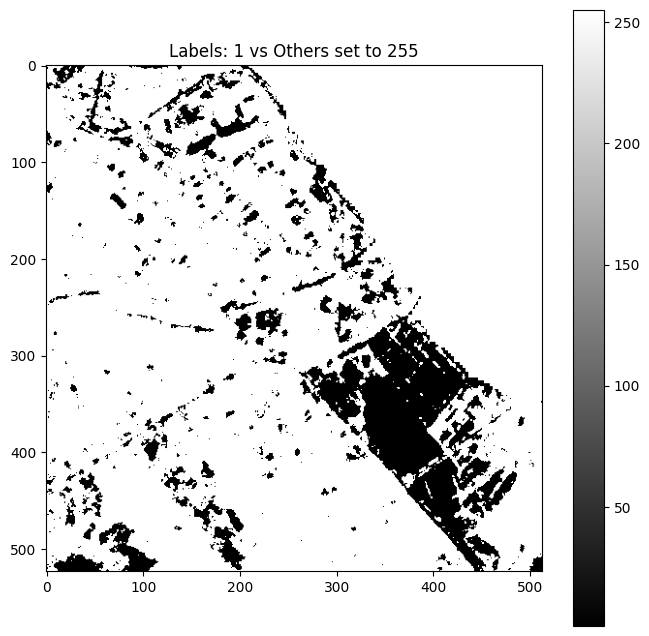

In [34]:
visual_labels = np.where(data == 1, 1, 255)

# Plot with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(visual_labels, cmap='gray')
plt.title('Labels: 1 vs Others set to 255')
plt.colorbar()
plt.show()

(-0.5, 512.5, 522.5, -0.5)

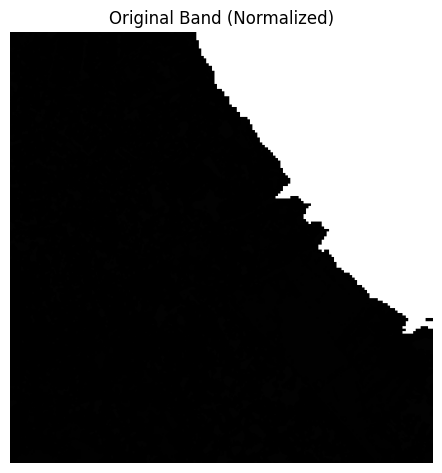

In [10]:
import cv2
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Band (Normalized)")
plt.imshow(data, cmap='gray')
plt.axis('off')

In [78]:
modified_labels = np.where(data == 255, 1, data)

In [79]:
np.unique(modified_labels)

array([0, 1, 2], dtype=uint8)

In [80]:
with rasterio.open("Sentinel_modified_label.tif", 'w', **profile) as dst:
    dst.write(modified_labels, 1)

print(f"Saved modified label file at Sentinel_modified_label.tif")

Saved modified label file at Sentinel_modified_label.tif


In [44]:
with rasterio.open("Sentinel_modified_label.tif") as src:
    data=src.read(1)
    profile=src.profile

In [45]:
data=((data/2)*255).astype(np.uint8)
profile.update(dtype=rasterio.uint8, count=1)
with rasterio.open("Sentinel_modified_label.tif", 'w', **profile) as dst:
    dst.write(data, 1)

print(f"Saved modified label file at Sentinel_modified_label.tif")

Saved modified label file at Sentinel_modified_label.tif


(-0.5, 512.5, 522.5, -0.5)

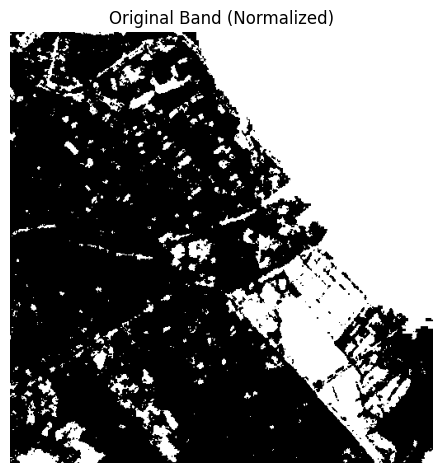

In [37]:
import cv2
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Band (Normalized)")
plt.imshow(data, cmap='gray')
plt.axis('off')

In [59]:
np.unique(data)

array([  0,   1,   2, 255], dtype=uint8)

In [87]:
with rasterio.open("20241220_023954_07_24a7_3B_AnalyticMS_clip.tif_kmeans.tif") as src:
    data=src.read(1)
    profile=src.profile

In [57]:
np.where(data==255)

(array([   0,    0,    0, ..., 1736, 1736, 1736], dtype=int64),
 array([   0,    1,    2, ..., 1701, 1702, 1703], dtype=int64))

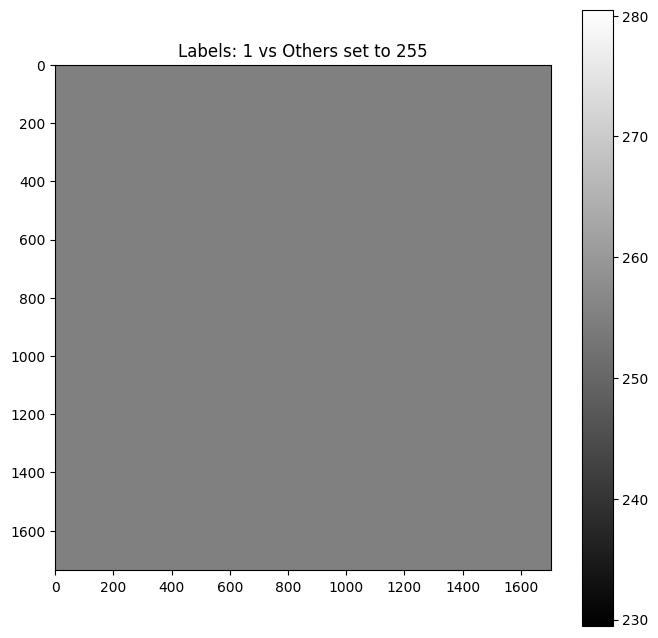

In [58]:
visual_labels = np.where(data == 255, 255, 255)

# Plot with matplotlib
plt.figure(figsize=(8, 8))
plt.imshow(visual_labels, cmap='gray')
plt.title('Labels: 1 vs Others set to 255')
plt.colorbar()
plt.show()

(-0.5, 1703.5, 1736.5, -0.5)

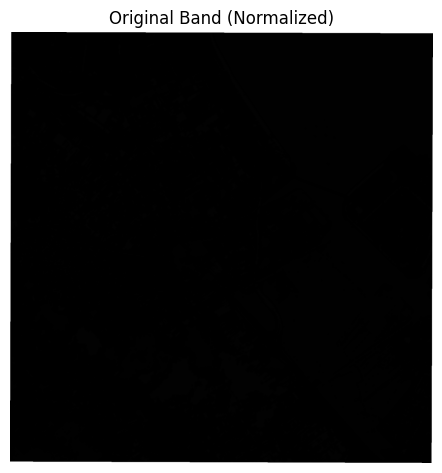

In [50]:
import cv2
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original Band (Normalized)")
plt.imshow(data, cmap='gray')
plt.axis('off')

In [88]:
modified_labels = np.where(data == 255, 1, data)

In [89]:
np.unique(modified_labels)

array([0, 1, 2], dtype=uint8)

In [90]:
data=((modified_labels/2)*255).astype(np.uint8)
profile.update(dtype=rasterio.uint8, count=1)
with rasterio.open("Planet_modified_label.tif", 'w', **profile) as dst:
    dst.write(data, 1)

print(f"Saved modified label file at Planet_modified_label.tif")

Saved modified label file at Planet_modified_label.tif


In [81]:
import numpy as np
import rasterio
from collections import Counter

def sliding_window(image, window_size, step_size):
    """
    Generator that yields patches of shape window_size with step step_size from image.
    Image shape assumed to be (H, W) or (C, H, W).
    """
    if image.ndim == 3:  # multiband image, shape (bands, H, W)
        bands, height, width = image.shape
    else:
        height, width = image.shape

    for y in range(0, height - window_size + 1, step_size):
        for x in range(0, width - window_size + 1, step_size):
            if image.ndim == 3:
                patch = image[:, y:y+window_size, x:x+window_size]
            else:
                patch = image[y:y+window_size, x:x+window_size]
            yield patch, (y, x)

def majority_class(patch_labels):
    """Return the majority class in the patch."""
    flat = patch_labels.flatten()
    most_common = Counter(flat).most_common(1)[0][0]
    return most_common

In [82]:
# Paths to your files
image_path = 'Sentinel_image.tif'
label_path = 'Sentinel_modified_label.tif'

window_size = 60
step_size = window_size // 2  # 50% overlap

# Read image and label
with rasterio.open(image_path) as src_img:
    # Read all bands, shape (bands, H, W)
    image = src_img.read()

with rasterio.open(label_path) as src_lbl:
    labels = src_lbl.read(1)  # single band labels (H, W)

In [83]:
image.shape

(3, 523, 513)

In [84]:
labels.shape

(523, 513)

In [85]:
# Prepare storage for patches and their labels
patches = []
patch_labels = []

for img_patch, (y, x) in sliding_window(image, window_size, step_size):
    label_patch = labels[y:y+window_size, x:x+window_size]

    # Calculate majority class label for patch
    maj_class = majority_class(label_patch)

    patches.append(img_patch)
    patch_labels.append(maj_class)

# Convert to arrays
patches = np.array(patches)           # shape: (num_patches, bands, 60, 60)
patch_labels = np.array(patch_labels) # shape: (num_patches,)

print(f"Extracted {len(patches)} patches")
print(f"Patches shape: {patches.shape}, Labels shape: {patch_labels.shape}")

# Now patches and patch_labels are ready for training EfficientNet:
# You may need to transpose patches to (num_patches, 60, 60, bands)
# and normalize them depending on your EfficientNet input requirements.


Extracted 256 patches
Patches shape: (256, 3, 60, 60), Labels shape: (256,)


In [86]:
import numpy as np

# Optional: transpose patches to (num_patches, height, width, channels) for EfficientNet
patches = patches.transpose(0, 2, 3, 1)  # from (N, bands, H, W) to (N, H, W, bands)

# Save patches and labels together in a compressed npz file
np.savez_compressed('lulc_patches_labels.npz', patches=patches, labels=patch_labels)

print("Saved patches and labels to 'lulc_patches_labels.npz'")


Saved patches and labels to 'lulc_patches_labels.npz'


In [91]:
# Paths to your files
image_path = '20241220_023954_07_24a7_3B_AnalyticMS_clip.tif'
label_path = 'Planet_modified_label.tif'

window_size = 224
step_size = window_size // 2  # 50% overlap

# Read image and label
with rasterio.open(image_path) as src_img:
    # Read all bands, shape (bands, H, W)
    image = src_img.read()

with rasterio.open(label_path) as src_lbl:
    labels = src_lbl.read(1)  # single band labels (H, W)

In [92]:
image.shape

(4, 1737, 1704)

In [93]:
labels.shape

(1737, 1704)

In [94]:
# Prepare storage for patches and their labels
patches = []
patch_labels = []

for img_patch, (y, x) in sliding_window(image, window_size, step_size):
    label_patch = labels[y:y+window_size, x:x+window_size]

    # Calculate majority class label for patch
    maj_class = majority_class(label_patch)

    patches.append(img_patch)
    patch_labels.append(maj_class)

# Convert to arrays
patches = np.array(patches)           # shape: (num_patches, bands, 60, 60)
patch_labels = np.array(patch_labels) # shape: (num_patches,)

print(f"Extracted {len(patches)} patches")
print(f"Patches shape: {patches.shape}, Labels shape: {patch_labels.shape}")

# Now patches and patch_labels are ready for training EfficientNet:
# You may need to transpose patches to (num_patches, 60, 60, bands)
# and normalize them depending on your EfficientNet input requirements.

Extracted 196 patches
Patches shape: (196, 4, 224, 224), Labels shape: (196,)


In [96]:
np.unique(patch_labels)

array([  0, 127, 255], dtype=uint8)

In [95]:
import numpy as np

# Optional: transpose patches to (num_patches, height, width, channels) for EfficientNet
patches = patches.transpose(0, 2, 3, 1)  # from (N, bands, H, W) to (N, H, W, bands)

# Save patches and labels together in a compressed npz file
np.savez_compressed('lulc_patches_labels_planet.npz', patches=patches, labels=patch_labels)

print("Saved patches and labels to 'lulc_patches_labels_planet.npz'")

Saved patches and labels to 'lulc_patches_labels_planet.npz'
